In [5]:
!pip install PyMuPDF


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 27.5 MB/s eta 0:00:00


Class distribution after RandomOverSampler: Counter({3: 40, 0: 40, 1: 40, 2: 40})
              precision    recall  f1-score   support

     English       1.00      1.00      1.00         8
 Mathematics       1.00      1.00      1.00         8
      Others       1.00      1.00      1.00         8
     Science       1.00      1.00      1.00         8

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



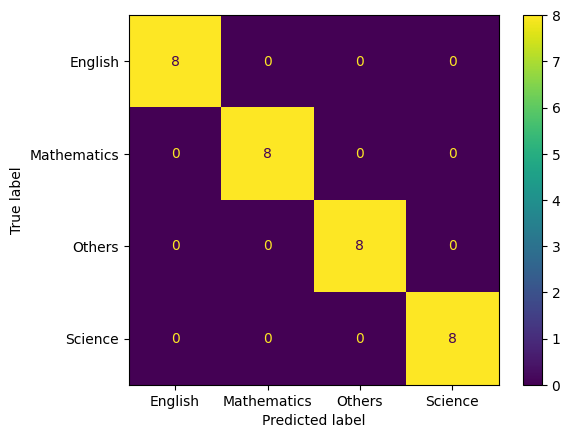

Top 10 positive features:
literature: 0.2723521049111503
test: 0.2685902013729744
writing: 0.26047263156086486
reading: 0.20842285340212646
level: 0.18467194854361704
date: 0.18365036973261642
vocabulary: 0.17999010754040146
outline: 0.16323233307501542
cloze: 0.1624456535382757
chapter: 0.16067062499438534

Top 10 negative features:
moves: -0.06222834156974536
stored: -0.06492802836413039
environments: -0.06690845960567592
things: -0.07176810257063225
new: -0.084963496598135
companies: -0.09416059241127502
york: -0.09423001951130547
lesson: -0.13029529555351
life: -0.1634658297565059
review: -0.20972180756840741


In [6]:
import fitz  # PyMuPDF
import re
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt

# Directory containing PDFs
pdf_directory = '/content/drive/MyDrive/CapstoneData'

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    pdf_document = fitz.open(pdf_path)
    text_data = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text = page.get_text()
        text_data.append(text)
    full_text = "\n".join(text_data)
    return full_text

# Function to preprocess the extracted text
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    chapters = text.split('CHAPTER')
    return chapters

# Function to classify text into subjects
def classify_subject(text):
    if re.search(r'\b(math|algebra|geometry|calculus)\b', text, re.IGNORECASE):
        return 'Mathematics'
    elif re.search(r'\b(english|literature|grammar|reading|writing)\b', text, re.IGNORECASE):
        return 'English'
    elif re.search(r'\b(science|biology|chemistry|physics)\b', text, re.IGNORECASE):
        return 'Science'
    else:
        return 'Others'

# Extract and preprocess text from all PDFs
preprocessed_text = []
for filename in os.listdir(pdf_directory):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_directory, filename)
        full_text = extract_text_from_pdf(pdf_path)
        preprocessed_text.extend(preprocess_text(full_text))

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=1, stop_words='english')
text_data_vectorized = vectorizer.fit_transform(preprocessed_text)

# Prepare the dataset
X = text_data_vectorized
y = [classify_subject(text) for text in preprocessed_text]

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply RandomOverSampler to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y_encoded)

# Check new class distribution
print("Class distribution after RandomOverSampler:", Counter(y_resampled))

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=label_encoder.transform(label_encoder.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()

# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = clf.coef_[0]
features_coefficients = sorted(zip(feature_names, coefficients), key=lambda x: x[1], reverse=True)

# Display top 10 positive and negative features
print("Top 10 positive features:")
for feature, coef in features_coefficients[:10]:
    print(f"{feature}: {coef}")

print("\nTop 10 negative features:")
for feature, coef in features_coefficients[-10:]:
    print(f"{feature}: {coef}")
